# Big project

## Submission

Submit solutions to https://forms.office.com/e/WexY7YraJb.

1.   Upload code in .ipynb file
2.   Upload a csv containing three columns: 
*    "ID": the ID of the instance (1, 2, 3, ...)
*    "OBJ": the objective function value obtained
*    "TIME": the execution time in seconds.

## Evaluation

1.   Gap w.r.t. optimal solutions
2.   Runtimes. Must be under 10 minutes for every instance[" Execution times will be re-examined on a random basis.

## Deadline

12/01/2022 23:59 CET

## Other

*   4 lab points just if you deliver something that works
*   10 points based on the quality of method
*   NO pre-coded libraries, 
*   NO genetic algorithms 
*   NO neural networks
*   groups of max 3 students




## Biogas plants location

An association of $n$ farmers wants to open $p$ plants to produce energy from biogas. 
Each plant will be opened at a farm of a member of the association and will be powered with corn chopping purchased from the farm itself or from other neighboring farms.

Each farm $i$ can provide at most $c_i$ tons of corn chopping, with a percentage of dry matter $a_i$. As you may know, dry matter is the key component of corn chopping used for biogas production. In order to maintain the quality of produced energy, each plant must burn a mixture of corn chopping with a percentage of dry matter between $k_{min}$ and $k_{max}$. 

At most one plant can be located in each farm, and every farm can sell its corn chopping to one and only one plant.

Each farm $i$ is located at coordinates $x_i$ and $y_i$, representing respectively its latitude and longitude, and the cost of moving corn chopping from a farm $i$ to a farm $j$ is proportional to the euclidean distance between the two farms (it does not depend on the actual quantity moved, since the trucks used for this transportations are sufficiently big). 

Under such conditions, every plant produces $Q$ kWh of energy per ton of corn chopping burned. The energy produced by each plant will be fed into the national electricity system, at a unitary price of $b$ (€/kWh). Moreover, due to state regulations, each plant must not produce more than $M$ kWh of energy.

You must locate $p$ plants among the available farms and assign the farms that will supply each plant, with the goal of maximizing the total revenues of the association.

### Sets
*   $I$ = set of farms

### Parameters
*   $n$ = number of farms   
*   $p$ = number of plants to locate
*   $b$ = revenue per unit of energy (€/kWh)
*   $M$ = max energy production (kWh)
*   $Q$ = energy produced by a ton of corn chopping (kWh/t)
*   $k_{min} (k_{max})$ = min (max) percentage of dry matter for fermentation
*   $a_i$ = percentage of dry matter in chopping from farm $i \in I$
*   $c_i$ = tons of corn chopping available for each $i \in I$ (t)
*   $x_i, y_i$ = coordinates of farm $i \in I$

In [1]:
import json

# Reads a .json instance and returns it in a dictionary
def load_instance(filename):
  with open(filename, 'r') as f:
    data = json.load(f)
  return data

# Reads a .txt result and returns it
def load_result(filename):
  with open(filename, 'r') as f:
      result = f.read()
  return float(result)

In [2]:
import mip
import math
import numpy as np

def fast_distance_matrix(x):
    x = np.array(x)
    #
    # Inspired by: 
    # https://github.com/eth-cscs/PythonHPC/blob/master/numpy/03-euclidean-distance-matrix-numpy.ipynb
    #
    # The "Euclidean Trick" math: 
    # https://www.robots.ox.ac.uk/~albanie/notes/Euclidean_distance_trick.pdf
    #
    xy = x @ x.T
    x2 = xy.diagonal()[:,np.newaxis]
    return np.abs(x2 + x2.T - 2. * xy)**0.5

def solve(instance):
  farms = range(instance["n"])        # number of farms
  plants = range(instance["p"])       # number of plants
  corn_chopping = instance["c"]       # vector of corn chopping production for each farm
  dry_matter = instance["a"]           # vector dry matter percentage per each farm
  farm_location = instance["points"]  # vector of farm locations (x,y)
  plant_efficency = instance["Q"]     # quantity of biogas produced per each plant per each ton of corn chopped
  energy_value = instance["b"]        # energy value of biogas (€/kWh)
  max_energy = instance["M"]        # energy limit for the whole system (kWh)
  min_dry_matter = instance["kmin"]
  max_dry_matter = instance["kmax"]

  m = mip.Model(name="biogas-plant-location", sense=mip.MAXIMIZE)
  
  ## Variables ##
  # x[i][j] = 1 if plant j is located at farm i
  x = [[m.add_var(var_type=mip.BINARY) for j in farms] for i in plants]

  # y[i][j] = 1 if farm i is connected to farm j
  y = [[m.add_var(var_type=mip.BINARY) for j in farms] for i in farms]

  # sold fuel from farm i
  sold_fuel = [[m.add_var() for i in farms] for j in farms]


  ## Constraints ##
  '''
  @vector of size p
  1 if plant i is built in any location
  0 otherwise
  '''
  is_plant_build = [mip.xsum(x[i][j] for j in farms) for i in plants]

  # each plant is connected to exactly one farm
  for i in plants:
    m += is_plant_build[i] == 1

  '''
  @vector
  listing the number of plants build in each farm
  '''
  plants_in_farm = [mip.xsum(x[i][j] for i in plants) for j in farms]

  # each farm has at most one plant
  for i in farms:
    m += plants_in_farm[i] <= 1


  '''
  @vector
  1 if farm i is connected to any other farm,
    the other farm must include a plant!
  0 otherwise
  '''
  farm_farm_connections = [mip.xsum(y[i][j] for j in farms) for i in farms]
 
  # each farm sell to at most one plant
  for i in farms:
    m += farm_farm_connections[i] <= 1

  # if y_ij = 1 then x_kj = 1 for any k in plants
  for i in farms:
    for j in farms:
      m += y[i][j] <= mip.xsum(x[k][j] for k in plants)
  
  '''
  not necessary => https://webeep.polimi.it/mod/forum/discuss.php?d=57341
  # farm i sell to a plant j
  for i in farms:
    m += mip.xsum(y[i][j] for j in farms) == 1
  '''

  # fuel can be sold only to connected farms
  for i in farms:
    for j in farms:
      m += sold_fuel[i][j] <= y[i][j] * corn_chopping[i]

  # fuel constraints
  bought_fuel = [mip.xsum(sold_fuel[i][j] for i in farms) for j in farms] 
  dry_matter_in_bought_fuel = [mip.xsum(sold_fuel[i][j] * dry_matter[i] for i in farms) for j in farms]
  for i in farms:
    m += dry_matter_in_bought_fuel[i] >= min_dry_matter * bought_fuel[i]
    m += dry_matter_in_bought_fuel[i] <= max_dry_matter * bought_fuel[i]

  # energy production cannot exceed limit
  for i in farms:
    m += bought_fuel[i] * plant_efficency <= max_energy
      

  ## Objective function ##

  # sold energy!
  earnings = mip.xsum(bought_fuel[i] * plant_efficency * energy_value for i in farms)

  # cost of transportation from farm i to plant j
  distance = fast_distance_matrix(farm_location)
  
  transp_cost = mip.xsum( distance[i][j] * y[i][j] for i in range(j, len(farms)) for j in farms)

  m.objective = mip.maximize(earnings - transp_cost)

  ## Optimization ##

  m.verbose = 0
  m.emphasis = 1 # FEASIBLE
  m.max_seconds = 600
  %time m.optimize(max_seconds=600)

  ## Output ##

  print("\nOptimization status: {}".format(m.status))
  print("Optimal solution: {}".format(m.objective_value))

  #plot the plants & farms
  plant_location = []
  for i in plants:
    for j in farms:
      if x[i][j].x == 1:
        plant_location.append(farm_location[j])
        break
  
  import matplotlib.pyplot as plt
  plt.scatter([x[0] for x in farm_location], [x[1] for x in farm_location], color='blue')
  plt.scatter([x[0] for x in plant_location], [x[1] for x in plant_location], color='red')
  
  plt.xlim(0, 100)
  plt.show()

  return m.objective_value

In [3]:
def test(n):
    inst = load_instance('instances/instance_'+str(n)+'.json')
    res = load_result("results/instance_"+str(n)+".txt")
    obj = solve(inst)
    print(res)

    print("goodness: " + str((obj - res) * 100 / res))

CPU times: user 43.2 ms, sys: 4.63 ms, total: 47.9 ms
Wall time: 48 ms

Optimization status: OptimizationStatus.OPTIMAL
Optimal solution: 1324617.2915704667


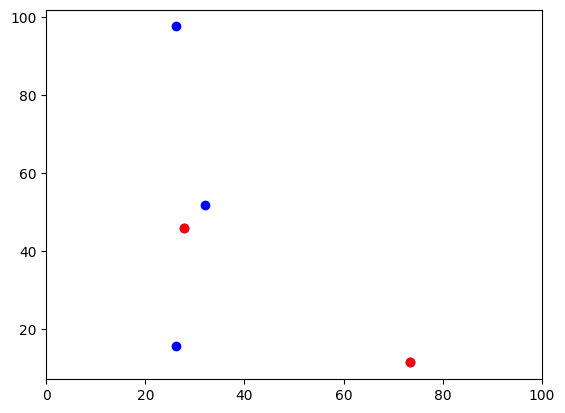

1324477.6736137536
goodness: 0.010541359774841356
CPU times: user 7.86 ms, sys: 705 µs, total: 8.57 ms
Wall time: 8.57 ms

Optimization status: OptimizationStatus.OPTIMAL
Optimal solution: 385739.65561196243


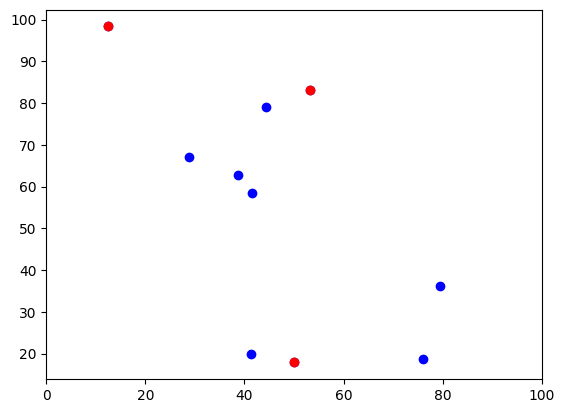

385611.91779212654
goodness: 0.03312600413578323
Cbc0038I Initial state - 8 integers unsatisfied sum - 2.47618
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 1.09185e+06 iterations 13
Cbc0038I Solution found of 1.09185e+06
Cbc0038I Relaxing continuous gives 1.12282e+06
Cbc0038I Before mini branch and bound, 28 integers at bound fixed and 25 continuous
Cbc0038I Full problem 72 rows 65 columns, reduced to 7 rows 6 columns
Cbc0038I Mini branch and bound improved solution from 1.12282e+06 to 1.30391e+06 (0.01 seconds)
Cbc0038I Freeing continuous variables gives a solution of 1.30391e+06
Cbc0038I Round again with cutoff of 1.3076e+06
Cbc0038I Reduced cost fixing fixed 1 variables on major pass 2
Cbc0038I Pass   2: suminf.    0.94716 (2) obj. 1.3076e+06 iterations 16
Cbc0038I Pass   3: suminf.    0.01856 (2) obj. 1.3076e+06 iterations 29
Cbc0038I Pass   4: suminf.    0.01856 (2) obj. 1.3076e+06 iterations 11
Cbc0038I Pass   5: suminf.    0.01856 (2) obj. 1.3076e+06 iterations 7
Cbc0038I Pass

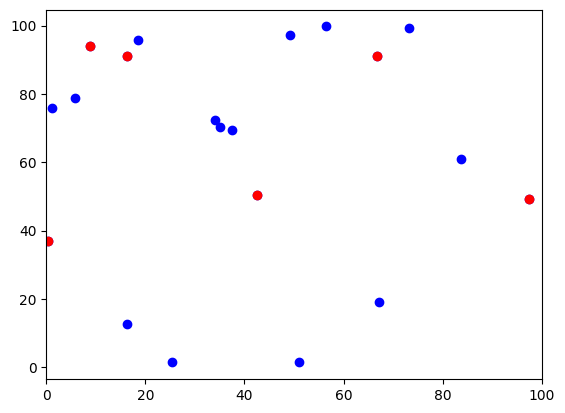

2357066.9429236925
goodness: 0.018442287650653064
CPU times: user 6.81 s, sys: 253 ms, total: 7.06 s
Wall time: 7.15 s

Optimization status: OptimizationStatus.OPTIMAL
Optimal solution: 9415090.927371463


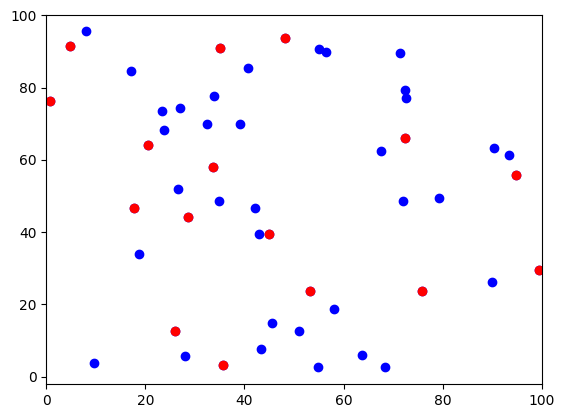

9414476.549923249
goodness: 0.006525880063073998


In [4]:
test(1)
test(2)
test(3)
test(4)

 possible 2358337.5 (550.53 seconds)
Cbc0010I After 125641 nodes, 8208 on tree, 2357501.6 best solution, best possible 2358337.5 (551.25 seconds)
Cbc0010I After 125860 nodes, 8202 on tree, 2357501.6 best solution, best possible 2358337.5 (551.95 seconds)
Cbc0010I After 126049 nodes, 8189 on tree, 2357501.6 best solution, best possible 2358337.5 (552.65 seconds)
Cbc0010I After 126172 nodes, 8198 on tree, 2357501.6 best solution, best possible 2358337.5 (553.36 seconds)
Cbc0010I After 126296 nodes, 8203 on tree, 2357501.6 best solution, best possible 2358337.5 (554.06 seconds)
Cbc0010I After 126428 nodes, 8208 on tree, 2357501.6 best solution, best possible 2358337.5 (554.77 seconds)
Cbc0010I After 126529 nodes, 8224 on tree, 2357501.6 best solution, best possible 2358337.5 (555.47 seconds)
Cbc0010I After 126698 nodes, 8227 on tree, 2357501.6 best solution, best possible 2358337.5 (556.17 seconds)
Cbc0010I After 126804 nodes, 8241 on tree, 2357501.6 best solution, best possible 2358337.5

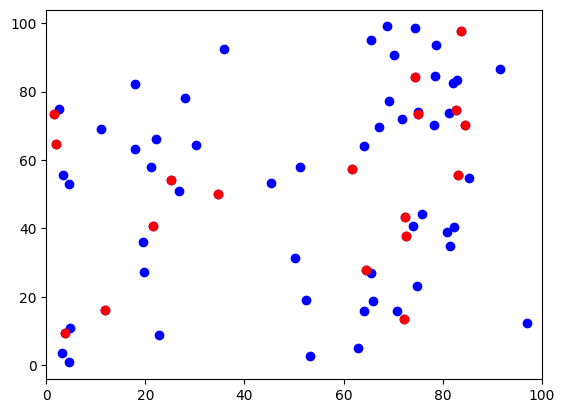

5803579.616998416

In [5]:
n = 5
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

49 (4) obj. 5.65223e+06 iterations 146
Cbc0038I Pass  22: (2.60 seconds) suminf.    1.00000 (4) obj. 5.65223e+06 iterations 229
Cbc0038I Pass  23: (2.85 seconds) suminf.   38.93195 (88) obj. 5.65223e+06 iterations 1108
Cbc0038I Pass  24: (3.02 seconds) suminf.    2.38253 (9) obj. 5.65223e+06 iterations 1041
Cbc0038I Pass  25: (3.06 seconds) suminf.    1.13750 (6) obj. 5.65223e+06 iterations 259
Cbc0038I Pass  26: (3.08 seconds) suminf.    1.13750 (6) obj. 5.65223e+06 iterations 7
Cbc0038I Pass  27: (3.12 seconds) suminf.    0.72370 (4) obj. 5.65223e+06 iterations 232
Cbc0038I Pass  28: (3.15 seconds) suminf.    0.66326 (4) obj. 5.65223e+06 iterations 167
Cbc0038I Pass  29: (3.17 seconds) suminf.    1.16045 (5) obj. 5.65223e+06 iterations 94
Cbc0038I Pass  30: (3.18 seconds) suminf.    1.16045 (5) obj. 5.65223e+06 iterations 0
Cbc0038I Pass  31: (3.21 seconds) suminf.    1.84641 (7) obj. 5.65223e+06 iterations 198
Cbc0038I No solution found this major pass
Cbc0038I Before mini branch an

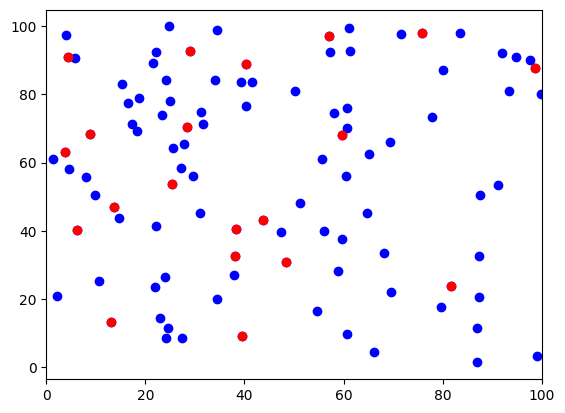

8164278.791609176

In [6]:
n = 6
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

 best solution, best possible 12118923 (468.71 seconds)
Cbc0010I After 2526 nodes, 2043 on tree, 7822060.1 best solution, best possible 12118923 (469.46 seconds)
Cbc0010I After 2532 nodes, 2049 on tree, 7822060.1 best solution, best possible 12118923 (471.12 seconds)
Cbc0010I After 2543 nodes, 2060 on tree, 7822060.1 best solution, best possible 12118923 (472.96 seconds)
Cbc0010I After 2560 nodes, 2077 on tree, 7822060.1 best solution, best possible 12118923 (473.67 seconds)
Cbc0010I After 2580 nodes, 2097 on tree, 7822060.1 best solution, best possible 12118923 (474.86 seconds)
Cbc0010I After 2598 nodes, 2115 on tree, 7822060.1 best solution, best possible 12118923 (475.68 seconds)
Cbc0010I After 2605 nodes, 2122 on tree, 7822060.1 best solution, best possible 12118923 (476.95 seconds)
Cbc0010I After 2608 nodes, 2125 on tree, 7822060.1 best solution, best possible 12118923 (478.77 seconds)
Cbc0010I After 2609 nodes, 2126 on tree, 7822060.1 best solution, best possible 12118923 (480.33

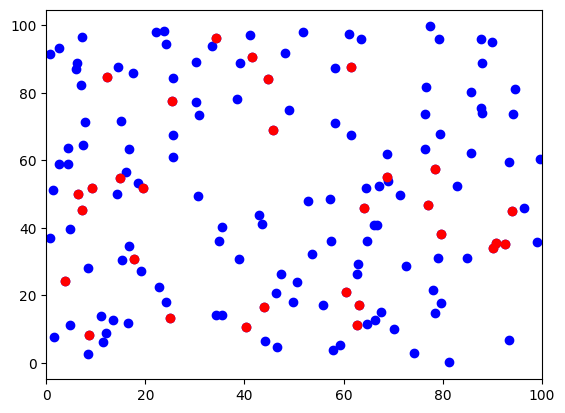

18490799.742134053

In [7]:
n = 7
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

CPU times: user 8min 19s, sys: 10.9 s, total: 8min 30s
Wall time: 11min 48s

Optimization status: OptimizationStatus.FEASIBLE
Optimal solution: 25284593.791342467


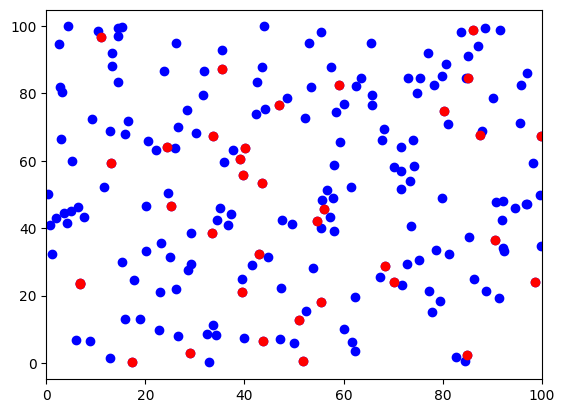

25284593.791342467

In [8]:
n = 8
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

e, 18490800 best solution, best possible 30454925 (464.54 seconds)
Cbc0010I After 221 nodes, 130 on tree, 18490800 best solution, best possible 30454925 (465.35 seconds)
Cbc0010I After 222 nodes, 130 on tree, 18490800 best solution, best possible 30454925 (467.49 seconds)
Cbc0010I After 223 nodes, 130 on tree, 18490800 best solution, best possible 30454925 (468.63 seconds)
Cbc0010I After 226 nodes, 132 on tree, 18490800 best solution, best possible 30454925 (471.25 seconds)
Cbc0010I After 229 nodes, 134 on tree, 18490800 best solution, best possible 30454925 (472.39 seconds)
Cbc0010I After 231 nodes, 135 on tree, 18490800 best solution, best possible 30454925 (473.44 seconds)
Cbc0010I After 232 nodes, 136 on tree, 18490800 best solution, best possible 30454925 (476.06 seconds)
Cbc0010I After 233 nodes, 136 on tree, 18490800 best solution, best possible 30454925 (476.81 seconds)
Cbc0010I After 235 nodes, 136 on tree, 18490800 best solution, best possible 30454925 (477.83 seconds)
Cbc001

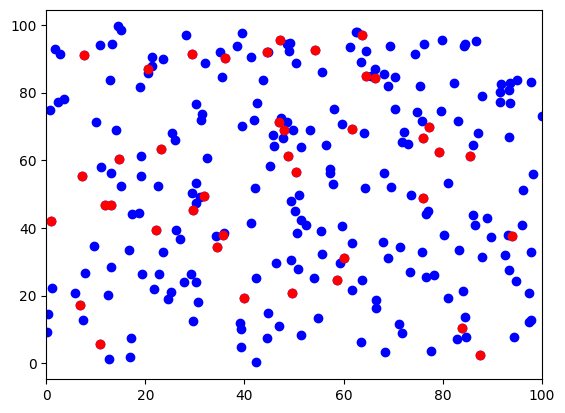

8883939.259787977

In [9]:
n = 9
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

In [ ]:
n = 10
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)